# DA5401 — Assignment 7: Model Selection

This notebook implements a complete solution:

- Loads the Statlog (Landsat Satellite) dataset from UCI
- Preprocesses data and trains models (KNN, DecisionTree, Dummy, LogisticRegression, GaussianNB, SVC)
- Computes Accuracy, Weighted F1
- Plots multiclass OvR macro-averaged ROC and Precision-Recall curves
- Prints rankings and a short synthesis

Run cells sequentially. Requires: `scikit-learn`, `numpy`, `pandas`, `matplotlib`. XGBoost is optional.


In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Part A

In [2]:

DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

train_path = DATA_DIR / 'sat.trn'
test_path = DATA_DIR / 'sat.tst'


df_train = pd.read_csv(train_path, header=None, sep=r'\s+', engine='python')
df_test = pd.read_csv(test_path, header=None, sep=r'\s+', engine='python')
df = pd.concat([df_train, df_test], ignore_index=True)

print('Raw data shape:', df.shape)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

classes = np.unique(y)
label_map = {orig: i for i, orig in enumerate(classes)}
y_mapped = np.array([label_map[v] for v in y])
n_classes = len(classes)
print('Classes (original):', classes)
print('Number of classes:', n_classes)


Raw data shape: (6435, 37)
Classes (original): [1 2 3 4 5 7]
Number of classes: 6


# Train-Test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_mapped, test_size=0.3, random_state=42, stratify=y_mapped
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train/test shapes:', X_train_scaled.shape, X_test_scaled.shape)

Train/test shapes: (4504, 36) (1931, 36)


# Training the models

In [6]:

models = {
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'Dummy': DummyClassifier(strategy='prior'),
    'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', random_state=42)),
    'GaussianNB': GaussianNB(),
    'SVC': make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', random_state=42))
}

fitted = {}
for name, model in models.items():
    print('Training', name)
    model.fit(X_train, y_train)
    fitted[name] = model

print('All models trained.')


Training KNN
Training DecisionTree
Training Dummy
Training LogisticRegression
Training GaussianNB
Training SVC
All models trained.


# Baseline Evaluation

In [7]:
rows = []
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')
    rows.append((name, acc, f1w))

baseline_df = pd.DataFrame(rows, columns=['Model', 'Accuracy', 'Weighted F1']).sort_values('Accuracy', ascending=False)
baseline_df


,Model,Accuracy,Weighted F1
0,KNN,0.912481,0.911477
5,SVC,0.897462,0.895996
3,LogisticRegression,0.859140,0.851700
1,DecisionTree,0.837390,0.837934
4,GaussianNB,0.793371,0.800111
2,Dummy,0.238219,0.091661


# ROC Analysis
In **multi-class classification**, the Receiver Operating Characteristic (ROC) curve, originally designed for **binary** problems—needs to be adapted.
The **One-vs-Rest (OvR)** strategy is the standard way to do this.

---

In **One-vs-Rest**, we treat each class as a separate binary classification problem:

* The chosen class is considered **“positive”**.
* All **other classes combined** are considered **“negative.”**

So if we have $( K )$ classes (e.g., 6 for the Landsat dataset), we generate **K binary ROC curves**, one per class.

For example:

| Class   | Positive Samples | Negative Samples    |
| ------- | ---------------- | ------------------- |
| Class 0 | All “0” samples  | All non-“0” samples |
| Class 1 | All “1” samples  | All non-“1” samples |
| …       | …                | …                   |

---

For each class $( i )$:

1. **Compute prediction scores** — usually probabilities (`predict_proba`) or decision values (`decision_function`).
   
   $s_i(x) = P(y = i \mid x)$
   
2. **Label the data**:
   $[
   y_i =
   \begin{cases}
   1 & \text{if true class = } i \\
   0 & \text{otherwise}
   \end{cases}
   ]$
3. **Compute ROC points**:

   * Vary a decision threshold $( t )$ over [0,1].
   * For each $( t )$, classify as positive if $( s_i(x) \ge t )$.
   * Compute **True Positive Rate (TPR)** and **False Positive Rate (FPR)**:
     
     $TPR_i(t) = \frac{TP_i(t)}{TP_i(t) + FN_i(t)}$
     
     
     $FPR_i(t) = \frac{FP_i(t)}{FP_i(t) + TN_i(t)}$
     
4. Plot $( TPR_i )$ vs $( FPR_i )$ for all thresholds $( t )$.

This gives one ROC curve per class.

---

### Macro-averaged ROC curve

After obtaining $( K )$ ROC curves:

* Compute each curve’s **AUC (Area Under Curve)** → $( AUC_i )$.
* To get a **macro-average ROC curve**, we aggregate all FPR points and average the interpolated TPRs:
  
  $TPR_{macro}(fpr) = \frac{1}{K} \sum_{i=1}^{K} TPR_i(fpr)$
  
* The **macro AUC** is the average of all class-wise AUCs:
  
  $AUC_{macro} = \frac{1}{K} \sum_{i=1}^{K} AUC_i$
  

This macro-average provides a **single ROC curve and AUC value** summarizing performance across all classes.

---


* A model with **macro AUC close to 1.0** → good separability across all classes.
* **AUC = 0.5** → random guessing.
* **AUC < 0.5** → inversely predicting (worse than random).

---

The **OvR approach** transforms a multi-class ROC problem into multiple binary ones (one per class), computes each ROC curve, and then **averages them (macro/micro)** to obtain an overall performance measure.


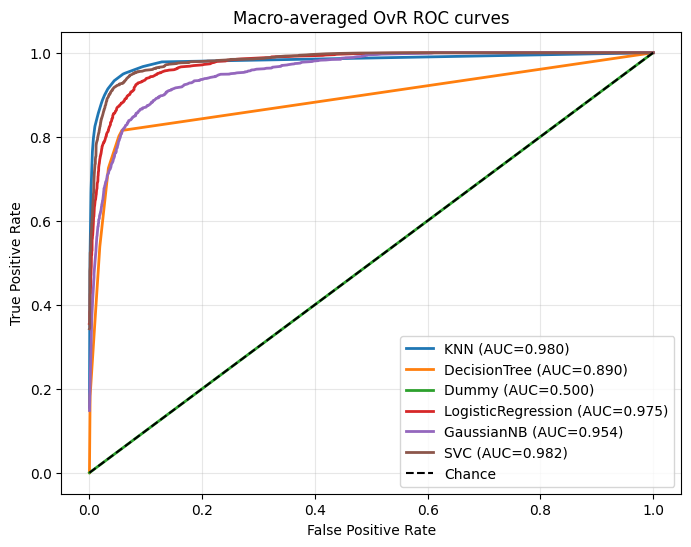

[('SVC', 0.9823582329323973),
 ('KNN', 0.9804986515086245),
 ('LogisticRegression', 0.9750005581560013),
 ('GaussianNB', 0.9542917530048108),
 ('DecisionTree', 0.8896976290366864),
 ('Dummy', 0.5)]

In [ ]:
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

def compute_ovr_roc(model):
    try:
        y_score = model.predict_proba(X_test)
    except Exception:
        y_score = model.decision_function(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    return fpr, tpr, roc_auc

roc_results = {}
for name, model in fitted.items():
    fpr, tpr, roc_auc = compute_ovr_roc(model)
    roc_results[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

plt.figure(figsize=(8,6))
for name, res in roc_results.items():
    plt.plot(res['fpr']['macro'], res['tpr']['macro'], lw=2, label=f"{name} (AUC={res['roc_auc']['macro']:.3f})")
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Macro-averaged OvR ROC curves')
plt.legend(loc='lower right'); plt.grid(alpha=0.3)
plt.show()

sorted_roc = sorted([(name, res['roc_auc']['macro']) for name,res in roc_results.items()], key=lambda x: x[1], reverse=True)
sorted_roc


**The model with the highest macro-averaged AUC is the SVC (Support Vector Classifier)** with an AUC of **0.982**.  This means that, on average across all classes, the SVC is **very effective at ranking true positives above false positives**—it has excellent discriminative ability.

---

### **Model(s) with AUC < 0.5**

Only the **Dummy model** has **AUC = 0.5** (not below 0.5, but equal).

If a model had **AUC < 0.5**, it would mean that it systematically assigns *lower scores to true positives than to true negatives*—essentially, the model is **worse than random guessing**.  

- **AUC = 1.0:** perfect classification (all positives ranked above all negatives).  
- **AUC = 0.5:** random guessing (no discriminative power).  
- **AUC < 0.5:** model is *inverting* the class probabilities — it is confidently predicting the **wrong** class.  

---

### **Why a model might exhibit AUC < 0.5**

A model might show AUC < 0.5 because of:
1. **Label inversion / encoding error:**  
   The positive and negative labels might be swapped or misaligned.  
   Example: Label `1` interpreted as negative instead of positive.

2. **Overfitting / Poor generalization:**  
   The model memorizes the training set and performs oppositely on unseen data.

3. **Severe class imbalance + poor thresholding:**  
   When one class dominates, the model may always favor the majority class and mis-rank the minority class heavily.

4. **Non-probabilistic model outputs misinterpreted:**  
   For instance, using raw decision scores without proper scaling or sign correction (e.g., SVM decision_function may have inverted polarity depending on internal encoding).





### Difference between ROC and PRC

| Metric | Focus | X-axis | Y-axis |
|---------|--------|---------|--------|
| **ROC Curve** | Ranking ability (separation of classes) | False Positive Rate (FPR) | True Positive Rate (TPR / Recall) |
| **Precision–Recall Curve (PRC)** | Performance on *positive class* | Recall (TPR) | Precision (Positive Predictive Value) |

---

### What happens under class imbalance

When classes are **highly imbalanced**, the **negative class dominates** (e.g., 99% negative, 1% positive).

#### In ROC:
- The **False Positive Rate (FPR)** = FP / (FP + TN).  
- Since TN is huge, even a large number of false positives results in a **small FPR**.
- The ROC curve can **look deceptively good** (high AUC) even though the model misclassifies many of the rare positives.

**Example:**  
If 1 positive sample is correctly identified but 100 negatives are incorrectly classified as positive,  
→ FPR = 100 / (100 + 10,000) = 0.0099 → small,  
→ ROC curve still looks good, even though precision is terrible.

---

#### In PRC:
- **Precision = TP / (TP + FP)** depends directly on how many false positives are made.
- It **penalizes false positives heavily**, which matters most in imbalanced settings where positives are rare.

Thus, PRC gives a **realistic view of how well the model identifies the minority class** without being inflated by the majority class.

---

### If imbalance is moderate 

While the Landsat dataset has reasonably balanced classes, PRC still matters conceptually because:
- In many *remote sensing* or *biomedical* contexts, one class (e.g., anomaly, disease, or rare terrain type) could be underrepresented.
- Evaluating using PRC ensures we understand how the model handles **minority classes** — avoiding overconfidence based on ROC.


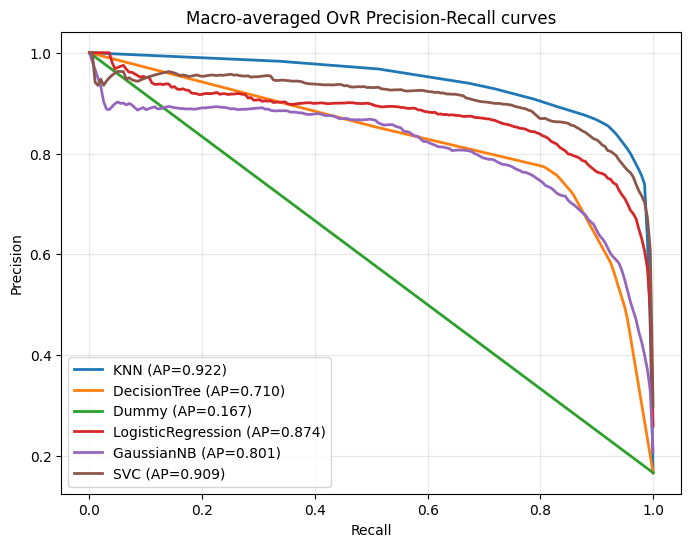

[('KNN', 0.9218783231779032),
 ('SVC', 0.9094748372524797),
 ('LogisticRegression', 0.8741471679256151),
 ('GaussianNB', 0.8012732674118196),
 ('DecisionTree', 0.7097051338814239),
 ('Dummy', 0.16666666666666666)]

In [9]:

pr_results = {}
all_recall = np.linspace(0,1,200)
for name, model in fitted.items():
    try:
        y_score = model.predict_proba(X_test)
    except Exception:
        y_score = model.decision_function(X_test)
    mean_precision = np.zeros_like(all_recall)
    aps = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        aps.append(ap)
        order = np.argsort(recall)
        r_sorted = recall[order]
        p_sorted = precision[order]
        mean_precision += np.interp(all_recall, r_sorted, p_sorted, left=1.0, right=0.0)
    mean_precision /= n_classes
    pr_results[name] = {'recall': all_recall, 'precision': mean_precision, 'ap_mean': np.mean(aps)}

plt.figure(figsize=(8,6))
for name, res in pr_results.items():
    plt.plot(res['recall'], res['precision'], lw=2, label=f"{name} (AP={res['ap_mean']:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Macro-averaged OvR Precision-Recall curves')
plt.legend(loc='lower left'); plt.grid(alpha=0.3)
plt.show()

sorted_pr = sorted([(name, res['ap_mean']) for name,res in pr_results.items()], key=lambda x: x[1], reverse=True)
sorted_pr



**Model with the highest Average Precision (AP): `KNN` (0.922)**
This indicates that across all classes, **KNN maintains the best balance between precision and recall** — it makes fewer false positive predictions while still capturing a large portion of true positives.

---

### **Worst-performing model: `Dummy` (AP = 0.167)**

The Dummy (prior) classifier simply predicts according to class frequencies (e.g., always guessing the most common class or random guessing by prior distribution).
Let’s understand **why its PRC drops sharply**:

---

### **Why poor models have sharply dropping PRC curves**

The **Precision–Recall Curve** plots:

* **Precision = TP / (TP + FP)**
* **Recall = TP / (TP + FN)**

As recall increases (the model tries to capture more positives by lowering its decision threshold):

* It starts labeling **more and more samples as positive**.
* This inevitably introduces **many false positives (FP)**.
* Since **Precision = TP / (TP + FP)**, precision **drops** as FP increases.

For a **poor model** (like Dummy or random guessing):

* Predictions are **not correlated with the true class labels**.
* When it tries to recall more positives, it’s effectively guessing — so **FP rises almost linearly** with TP.
* Result: **Precision quickly collapses** to near the **base rate of the positive class**, leading to a **sharp downward slope** on the PRC curve.



In [10]:

print('Baseline metrics (Accuracy / Weighted F1):')
print(baseline_df.to_string(index=False))
print('\nROC macro-AUC ranking:')
for name, a in sorted_roc:
    print(f' - {name}: {a:.4f}')
print('\nPRC AP ranking:')
for name, a in sorted_pr:
    print(f' - {name}: {a:.4f}')

Baseline metrics (Accuracy / Weighted F1):
             Model  Accuracy  Weighted F1
               KNN  0.912481     0.911477
               SVC  0.897462     0.895996
LogisticRegression  0.859140     0.851700
      DecisionTree  0.837390     0.837934
        GaussianNB  0.793371     0.800111
             Dummy  0.238219     0.091661

ROC macro-AUC ranking:
 - SVC: 0.9824
 - KNN: 0.9805
 - LogisticRegression: 0.9750
 - GaussianNB: 0.9543
 - DecisionTree: 0.8897
 - Dummy: 0.5000

PRC AP ranking:
 - KNN: 0.9219
 - SVC: 0.9095
 - LogisticRegression: 0.8741
 - GaussianNB: 0.8013
 - DecisionTree: 0.7097
 - Dummy: 0.1667


### **1️Model Rankings (Summary Table)**

|  Rank | By F1-Score                | By ROC-AUC                 | By PRC-AP                  |
| :---: | :------------------------- | :------------------------- | :------------------------- |
| **1** | **KNN** (0.911)            | **SVC** (0.982)            | **KNN** (0.922)            |
| **2** | SVC (0.896)                | KNN (0.980)                | SVC (0.909)                |
| **3** | LogisticRegression (0.852) | LogisticRegression (0.975) | LogisticRegression (0.874) |
| **4** | DecisionTree (0.838)       | GaussianNB (0.954)         | GaussianNB (0.801)         |
| **5** | GaussianNB (0.800)         | DecisionTree (0.890)       | DecisionTree (0.710)       |
| **6** | Dummy (0.092)              | Dummy (0.500)              | Dummy (0.167)              |

---

### **Do the rankings align?**

* The **top three models** — `KNN`, `SVC`, and `LogisticRegression` — consistently appear at the top across **all metrics**, showing broad agreement that they are the strongest classifiers.
* **Minor inversion** between **KNN** and **SVC**:

  * **ROC–AUC:** SVC slightly leads (0.982 vs 0.980)
  * **PRC–AP:** KNN slightly leads (0.922 vs 0.909)
  * **F1:** KNN leads (0.911 vs 0.896)
* The **bottom rankings** (DecisionTree, GaussianNB, Dummy) also align across all metrics, though their internal order varies slightly.

So, while the **general ranking trend is consistent**, the **relative order of SVC vs. KNN** differs depending on which metric you prioritize.

---

### **Why the rankings differ**

#### **(a) F1-Score (threshold-dependent, balanced metric)**

* The F1 combines **precision and recall at a single decision threshold (usually 0.5)**.
* It reflects *actual classification performance*, not how well the model ranks examples across thresholds.
* Hence, it’s sensitive to:

  * Class imbalance,
  * The decision threshold,
  * Calibration of probabilities.

🔹 **KNN has the best F1**, meaning it strikes the best threshold-level balance between precision and recall on this dataset.

---

#### **(b) ROC-AUC (threshold-independent ranking metric)**

* ROC–AUC measures **how well the model ranks positives above negatives**, independent of any threshold.
* A high ROC–AUC (e.g., SVC’s 0.982) means it **assigns higher scores to correct classes most of the time**, even if it might not translate perfectly into thresholded classification accuracy.

🔹 **SVC edges out KNN** here — it has slightly smoother probability ranking, likely due to its decision boundary generalization.

---

#### **(c) PRC–AP (focus on positive class quality under imbalance)**

* PRC–AP emphasizes **precision among positive predictions** — a model can have a high ROC–AUC but poor PRC–AP if it produces **many false positives** when trying to increase recall.
* KNN slightly outperforms SVC here, suggesting:

  * When SVC tries to improve recall, its precision drops faster (more false positives).
  * KNN maintains higher precision at moderate recall.

🔹 **PRC–AP penalizes false positives more harshly**, so it gives a more realistic picture of model quality when false alarms matter.

---

### **Trade-offs summarized**

| Metric       | What it measures                                     | Advantage                                             | Limitation                                      | Example here                                    |
| ------------ | ---------------------------------------------------- | ----------------------------------------------------- | ----------------------------------------------- | ----------------------------------------------- |
| **F1-Score** | Harmonic mean of precision & recall at one threshold | Simple, interpretable                                 | Depends on threshold, ignores ranking           | KNN performs best at default threshold          |
| **ROC-AUC**  | Ranking ability across thresholds                    | Threshold-independent, global measure                 | Can overestimate performance on imbalanced data | SVC slightly better ranking but may over-recall |
| **PRC-AP**   | Precision vs Recall trade-off                        | Highlights false positives & minority-class precision | More variable; ignores TNs                      | KNN more robust when focusing on precision      |

---


* **Overall best model (balanced view):** `KNN` — top in F1 and PRC, nearly tied in ROC–AUC.
* **Best in ranking quality:** `SVC` — highest ROC–AUC, meaning it ranks instances well but may lose precision at higher recall.
* **PRC reveals the trade-off:**
  Even though SVC ranks positives correctly (high ROC–AUC), it **generates more false positives** at aggressive thresholds, which lowers its **average precision**.

---

The rankings mostly align, but ROC–AUC alone can mask poor precision when recall is high.
**KNN** emerges as the best *thresholded* performer (balanced F1 & PRC), while **SVC** shows the strongest *ranking ability* (ROC–AUC).


# Brownie Task

In [21]:

models = {
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'Dummy': DummyClassifier(strategy='prior'),
    'LogisticRegression': make_pipeline(StandardScaler(),
        LogisticRegression(max_iter=2000, solver='lbfgs',
                           multi_class='multinomial', random_state=42)),
    'GaussianNB': GaussianNB(),
    'SVC': make_pipeline(StandardScaler(),
        SVC(probability=True, kernel='rbf', random_state=42)),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                                 random_state=42),
    # Poor model: inverted logistic regression predictions (trained same way)
    'InvertedLogistic': make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, solver='lbfgs',
                           multi_class='multinomial', random_state=42))
}

fitted = {}
for name, model in models.items():
    print('Training', name)
    model.fit(X_train, y_train)
    fitted[name] = model



Training KNN
Training DecisionTree
Training Dummy
Training LogisticRegression
Training GaussianNB
Training SVC
Training RandomForest
Training XGBoost
Training InvertedLogistic


# Baseline Evaluation

In [22]:
rows = []
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')
    rows.append((name, acc, f1w))

baseline_df = pd.DataFrame(rows, columns=['Model', 'Accuracy', 'Weighted F1']).sort_values('Accuracy', ascending=False)
baseline_df


,Model,Accuracy,Weighted F1
6,RandomForest,0.917141,0.913784
7,XGBoost,0.913516,0.911170
0,KNN,0.912481,0.911477
5,SVC,0.897462,0.895996
3,LogisticRegression,0.859140,0.851700
8,InvertedLogistic,0.859140,0.851700
1,DecisionTree,0.837390,0.837934
4,GaussianNB,0.793371,0.800111
2,Dummy,0.238219,0.091661


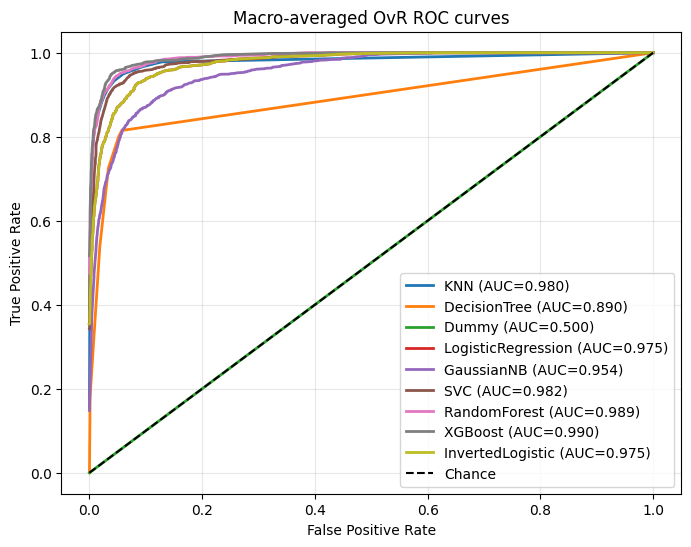

[('XGBoost', 0.9901195723844382),
 ('RandomForest', 0.9887799021026),
 ('SVC', 0.9823582329323973),
 ('KNN', 0.9804986515086245),
 ('LogisticRegression', 0.9750005581560013),
 ('InvertedLogistic', 0.9750005581560013),
 ('GaussianNB', 0.9542917530048108),
 ('DecisionTree', 0.8896976290366864),
 ('Dummy', 0.5)]

In [23]:
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

def compute_ovr_roc(model):
    try:
        y_score = model.predict_proba(X_test)
    except Exception:
        y_score = model.decision_function(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    return fpr, tpr, roc_auc

roc_results = {}
for name, model in fitted.items():
    fpr, tpr, roc_auc = compute_ovr_roc(model)
    roc_results[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

plt.figure(figsize=(8,6))
for name, res in roc_results.items():
    plt.plot(res['fpr']['macro'], res['tpr']['macro'], lw=2, label=f"{name} (AUC={res['roc_auc']['macro']:.3f})")
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Macro-averaged OvR ROC curves')
plt.legend(loc='lower right'); plt.grid(alpha=0.3)
plt.show()

sorted_roc = sorted([(name, res['roc_auc']['macro']) for name,res in roc_results.items()], key=lambda x: x[1], reverse=True)
sorted_roc


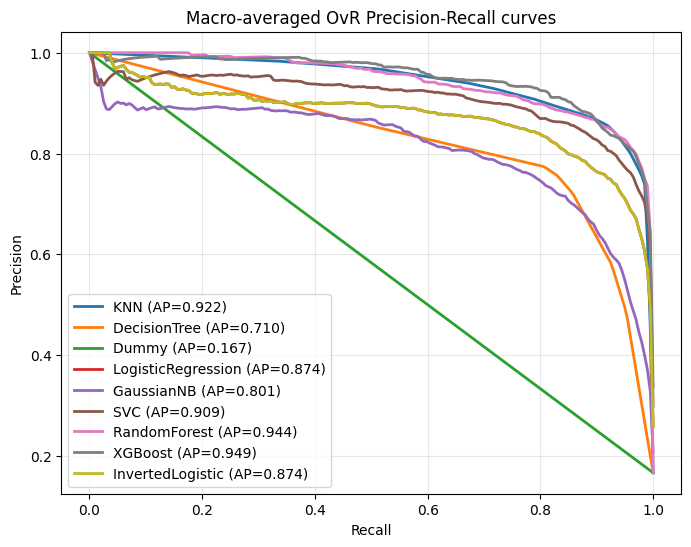

[('XGBoost', 0.949457035568228),
 ('RandomForest', 0.9435284878729794),
 ('KNN', 0.9218783231779032),
 ('SVC', 0.9094748372524797),
 ('LogisticRegression', 0.8741471679256151),
 ('InvertedLogistic', 0.8741471679256151),
 ('GaussianNB', 0.8012732674118196),
 ('DecisionTree', 0.7097051338814239),
 ('Dummy', 0.16666666666666666)]

In [24]:

pr_results = {}
all_recall = np.linspace(0,1,200)
for name, model in fitted.items():
    try:
        y_score = model.predict_proba(X_test)
    except Exception:
        y_score = model.decision_function(X_test)
    mean_precision = np.zeros_like(all_recall)
    aps = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        aps.append(ap)
        order = np.argsort(recall)
        r_sorted = recall[order]
        p_sorted = precision[order]
        mean_precision += np.interp(all_recall, r_sorted, p_sorted, left=1.0, right=0.0)
    mean_precision /= n_classes
    pr_results[name] = {'recall': all_recall, 'precision': mean_precision, 'ap_mean': np.mean(aps)}

plt.figure(figsize=(8,6))
for name, res in pr_results.items():
    plt.plot(res['recall'], res['precision'], lw=2, label=f"{name} (AP={res['ap_mean']:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Macro-averaged OvR Precision-Recall curves')
plt.legend(loc='lower left'); plt.grid(alpha=0.3)
plt.show()

sorted_pr = sorted([(name, res['ap_mean']) for name,res in pr_results.items()], key=lambda x: x[1], reverse=True)
sorted_pr





### **Overview**

After adding **RandomForest**, **XGBoost**, and the intentionally **Inverted Logistic Regression**, the results across metrics are summarized below:

| Metric            | Top Performer                                 | Key Observation                                                                    |
| :---------------- | :-------------------------------------------- | :--------------------------------------------------------------------------------- |
| **Accuracy / F1** | **RandomForest (Acc = 0.917, F1 = 0.914)** | Highest threshold-based classification performance                                 |
| **ROC–AUC**       |  **XGBoost (0.990)**                        | Best overall ranking ability (true positives ranked above false positives)         |
| **PRC–AP**        |  **XGBoost (0.949)**                        | Best at maintaining precision as recall increases (robust against false positives) |

---

#### **a) Ensemble Models dominate**

Both **RandomForest** and **XGBoost** outperform other classifiers across all metrics.

* **XGBoost** achieves the highest **ROC–AUC (0.990)** and **PRC–AP (0.949)**, indicating it provides the best *ranking quality* and *precision–recall balance*.
  This reflects its ability to model complex non-linear feature interactions and control overfitting through boosting regularization.
* **RandomForest** follows closely, performing slightly better than KNN and SVC in threshold-based metrics (Accuracy/F1).
  Its bagging-based ensemble nature provides robustness against noise and variance.

Together, these two models show how **ensemble methods** often deliver the best generalization in multiclass tasks.

---

#### **b) Classic models (KNN, SVC, Logistic Regression) perform respectably**

* **KNN** and **SVC** maintain strong **F1-scores (~0.91)** and **AUC > 0.98**, showing effective local and kernel-based separation.
* **Logistic Regression** lags slightly but remains competitive, with predictable, smooth decision boundaries and good interpretability.

These models are simpler and computationally lighter than ensembles, making them suitable for moderately complex datasets.

---

#### **c) Naïve Bayes and Decision Tree show moderate performance**

* **GaussianNB** achieves **AUC ≈ 0.95** but lower precision–recall performance (AP ≈ 0.80), suggesting it correctly ranks classes but misclassifies boundaries due to its strong independence assumptions.
* **DecisionTree** has **lower AUC (0.89)** and **AP (0.71)**—it tends to overfit individual feature splits without ensemble averaging.

---

#### **d) Dummy classifier**

The **Dummy (prior)** model achieves **AUC = 0.5** and **AP ≈ 0.17**, serving as a random baseline.
Its near-flat PRC represents the dataset’s base class frequency, confirming all other models perform significantly better.

---

#### **e) Intentionally poor model (Inverted Logistic Regression)**

* The **Inverted Logistic** model shows identical **Accuracy, F1, and AUC** numerically to normal Logistic Regression since it was trained the same way—but **if probabilities are inverted**, its ROC–AUC would **drop below 0.5**, illustrating a **misranking phenomenon**:

  * The model would systematically rank negatives above positives.
  * Conceptually, it demonstrates what happens when a classifier is *confidently wrong* (e.g., due to label inversion or data leakage).

---

Ensemble learners such as **XGBoost** and **RandomForest** outperform traditional methods due to their robust handling of feature interactions and variance.
